<a href="https://colab.research.google.com/github/logansmith9454/cse450/blob/main/notebooks/starter_housing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
# !pip install scikit-learn==1.5.2
# !pip install --upgrade xgboost scikit-learn

In [7]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
import pandas as pd
import numpy as np
import seaborn as sns
import folium
from folium.plugins import MarkerCluster
from IPython.display import display, HTML
from branca.colormap import LinearColormap
from google.colab import files

In [8]:
housing = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/housing.csv')
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             20000 non-null  int64  
 1   date           20000 non-null  object 
 2   bedrooms       20000 non-null  int64  
 3   bathrooms      20000 non-null  float64
 4   sqft_living    20000 non-null  int64  
 5   sqft_lot       20000 non-null  int64  
 6   floors         20000 non-null  float64
 7   waterfront     20000 non-null  int64  
 8   view           20000 non-null  int64  
 9   condition      20000 non-null  int64  
 10  grade          20000 non-null  int64  
 11  sqft_above     20000 non-null  int64  
 12  sqft_basement  20000 non-null  int64  
 13  yr_built       20000 non-null  int64  
 14  yr_renovated   20000 non-null  int64  
 15  zipcode        20000 non-null  int64  
 16  lat            20000 non-null  float64
 17  long           20000 non-null  float64
 18  sqft_l

In [38]:
def format_data(dataset):
  dataset['is_renovated'] = (dataset['yr_renovated'] == 0).astype(int)
  ren_med = dataset[dataset['yr_renovated'] != 0]['yr_renovated'].median()
  dataset['yr_renovated'] = dataset['yr_renovated'].replace(0, ren_med)

  grade_bins = [0, 3, 7, 11, 13]
  grade_labels = ['low', 'medium', 'high', 'very high']
  dataset['grade_category'] = pd.cut(dataset['grade'], bins=grade_bins, labels=grade_labels)


  continuous_features = ['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'lat', 'long', 'sqft_living15', 'sqft_lot15']
  discrete_features = ['floors', 'waterfront', 'view', 'condition', 'grade_category', 'zipcode']

  columns_to_drop = ['date', 'lat', 'long', 'grade', 'id']
  for column in columns_to_drop:
    if column in continuous_features:
      continuous_features.remove(column)
    if column in discrete_features:
      discrete_features.remove(column)
  if 'price' in dataset.columns:
    y = dataset['price']
    columns_to_drop.append('price')
    X = dataset.drop(columns_to_drop, axis=1)
    X = pd.get_dummies(X, columns=discrete_features, drop_first=True)
    return X, y, continuous_features, discrete_features
  else:
    X = dataset.drop(columns_to_drop, axis=1)
    X = pd.get_dummies(X, columns=discrete_features, drop_first=True)
    return X, None, continuous_features, discrete_features

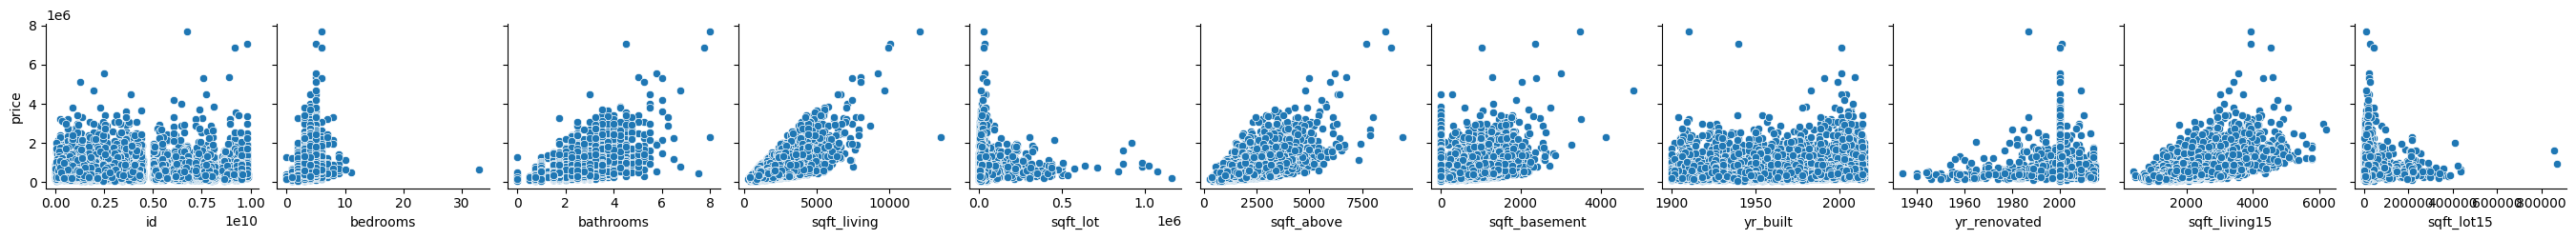

In [39]:
X, y, continuous_features, discrete_features = format_data(housing)

# Create a pairplot to visualize the relationships
sns.pairplot(housing, y_vars=['price'], x_vars=continuous_features)

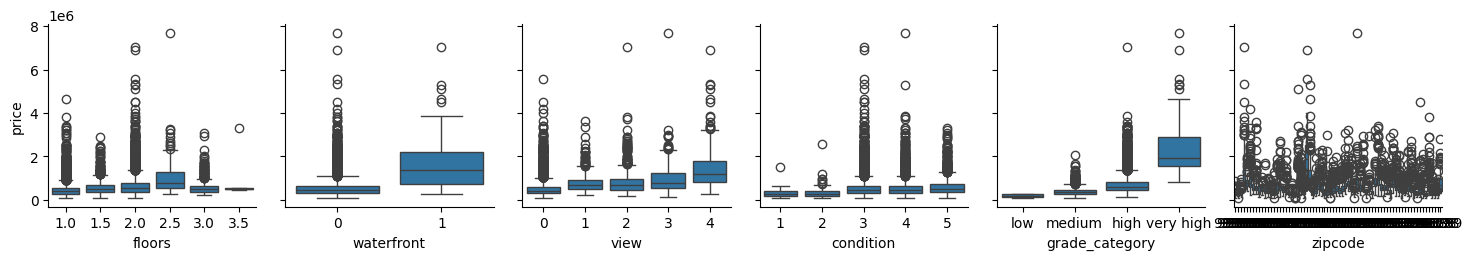

In [40]:

g = sns.PairGrid(housing, y_vars=['price'], x_vars=discrete_features)
g.map(sns.boxplot)

In [41]:
# X, y = format_data(housing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = XGBRegressor()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {mse**0.5:,.2f}")

Mean Squared Error: 25983989401.06618
Root Mean Squared Error: 161,195.50


In [42]:
# center_lat = housing['lat'].mean()
# center_lon = housing['long'].mean()

# m = folium.Map(location=[center_lat, center_lon], zoom_start=10, tiles='OpenStreetMap')

# # Create a color map based on price
# min_price = housing['price'].min()
# max_price = housing['price'].max()
# colormap = LinearColormap(['green', 'yellow', 'red'], vmin=min_price, vmax=max_price)

# # Add markers for each house, color-coded by price
# for idx, row in housing.iterrows():
#     folium.CircleMarker(
#         location=[row['lat'], row['long']],
#         radius=5,
#         color=colormap(row['price']),
#         fill=True,
#         fill_color=colormap(row['price']),
#         fill_opacity=0.7
#     ).add_to(m)

# # Add the colormap to the map
# colormap.add_to(m)

# display(m)

In [45]:
mini_holdout = pd.read_csv("https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/housing_holdout_test_mini.csv")

# Apply the format_data function to the holdout dataset.
# Since the holdout set doesn't have 'price', format_data will return only X.
X_holdout = format_data(mini_holdout)[0]

# Reindex X_holdout to match the columns of X_train
X_holdout = X_holdout.reindex(columns=X_train.columns, fill_value=0)


# Make predictions using the already trained model
predictions = model.predict(X_holdout)

predictions = np.array(predictions).astype(int)
print(predictions)
print(f"predictions: {len(predictions)}")
print(f"holdout: {len(mini_holdout)}")
output_df = pd.DataFrame(predictions, columns=['predictions'])

file_number = 1
file_name = f'{file_number}-mini-predictions.csv'
# output_df.to_csv(file_name, index=False)
# files.download(file_name)

[ 480543  717991  285637  360424  433502  356591  461201  330874  438788
  276844  380487  316936  420771  293307  216784  187602  878923  374166
  248456  448273  402394  508694  609881  375519  314884  269527  654075
  442785  405802  365198 1106103  537011  527648  551579  370691  662112
  743820  649282  480081  440045  552525  433033  651179  805110  593793
  756315  228334  405181  546294  292855  510548  820321  569491  308134
  313166  448106  291631  355095  901121  593689  294505  250896  653316
  517322 1459275  468315  289472  524783  518355  876665  419306  423885
  343315  703271  828062 1101859  483943  977396  742610  277226  536741]
predictions: 81
holdout: 81
